# Face Generative Adversial Network 

Challenge_1: Use the CelebA dataset to generate realistic faces using a DCGAN <br>
Challenge_2: Understand and extract the internal structure of the faces to create customizable and unique faces<br>
Challenge_3: Face interpolation

Tip: Train the network with low res first and the increase resolution 

In [1]:
# load libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda") 

data_dir = "data/img_align_celeba/"

image_list = [os.path.join(data_dir, i)
              for i in os.listdir(data_dir)]

First let's explore the image dataset

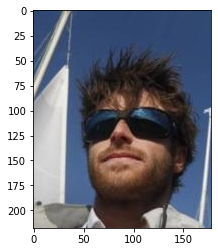

In [2]:
image = cv2.imread(image_list[3])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [3]:
image.shape

(218, 178, 3)

### Create Dataset

In [4]:
imsize = 64

transform = transforms.Compose(
    [transforms.Resize(imsize),
     transforms.CenterCrop(imsize),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize between [-1 1]


dataset = torchvision.datasets.ImageFolder(root="data/",
                           transform=transform)

batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


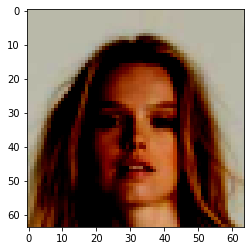

In [5]:
# visualize image from dataset
dataiter = iter(dataloader)
d, l = dataiter.next()
plt.imshow(np.transpose(d[2], (1, 2, 0)))
plt.show()

### Define Architecture

In [6]:
# auxiliar layers 
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class UnFlatten(nn.Module):
    
    def __init__(self, channels, sx, sy):
        super(UnFlatten, self).__init__()
        self.channels = channels
        self.sx = sx
        self.sy = sy
    
    def forward(self, input):
        return input.view(input.size(0), self.channels, 
                          self.sx, self.sy)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            # in_filters, out_filters, kernel, stride, padding
            nn.Conv2d(3,  64, 4, 2, 1), # conv1 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, # conv2 I=32x32 
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, # conv3 I=16x16
                      stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=4, # conv4 O=2x2
                      stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, # conv5 
                      stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True), # conv6
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.net(input)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, #conv1
                               stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, #conv2
                               stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, kernel_size=4, #conv3
                               stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, #conv4
                               stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64,kernel_size=4,#conv5
                               stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4,#conv6
                               stride=2, padding=1),
            nn.Tanh()
            
            )
    def forward(self, input):
        return self.net(input)

### Train Model

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

n_epochs = 10

criterion = nn.BCELoss()

dis_learning_rate = 0.0002
gen_learning_rate = 0.0002
dis_optimizer = optim.Adam(discriminator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(generator.parameters(),
                           dis_learning_rate, betas=(0.5, 0.999))

# trues and fake values 

# keep track of progress
G_losses = []
D_losses = []

for epoch in range(n_epochs):
    
    for i, data in enumerate(dataloader, 0): 
        # load image batch
        image, _ = data
        image = image.to(device)
        batch_size = image.size()[0]
        trues = torch.ones([batch_size, 1], device=device)
        fakes = torch.zeros([batch_size, 1], device=device)
        
        # zero grads
        dis_optimizer.zero_grad()
        
        
        # TRAIN DISCRIMINATIVE
        # true batch
        out = discriminator(image).view(-1, 1)
        loss_real = criterion(out, trues)
        loss_real.backward(retain_graph=True)
        # fake batch
        noise = torch.randn(batch_size, 100, 1, 1, device=device)

        fake = generator(noise)
        out = discriminator(fake).view(-1, 1)
        loss_fake = criterion(out, fakes)
        loss_fake.backward(retain_graph=True)
        lossD = loss_real + loss_fake
        dis_optimizer.step()
        
        # TRAIN GENERATOR
        # zero grads
        gen_optimizer.zero_grad()
        
        out = discriminator(fake).view(-1, 1)
        lossG = criterion(out, trues)
        lossG.backward()
        gen_optimizer.step()
        if i % 100 == 0:
            torch.save(discriminator.state_dict(), "models/discriminator_state.pt")
            torch.save(generator.state_dict(), "models/generator_state.pt")
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, n_epochs, i, len(dataloader),
                     lossD.item(), lossG.item()))
        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        

[0/10][0/6332]	Loss_D: 1.4494	Loss_G: 2.1383	
[0/10][100/6332]	Loss_D: 0.0591	Loss_G: 4.4902	
[0/10][200/6332]	Loss_D: 0.0905	Loss_G: 4.6892	
[0/10][300/6332]	Loss_D: 0.0254	Loss_G: 5.3009	
[0/10][400/6332]	Loss_D: 0.4303	Loss_G: 2.4957	
[0/10][500/6332]	Loss_D: 0.6329	Loss_G: 2.5341	
[0/10][600/6332]	Loss_D: 0.1090	Loss_G: 4.6615	
[0/10][700/6332]	Loss_D: 0.0650	Loss_G: 4.5049	
[0/10][800/6332]	Loss_D: 0.0591	Loss_G: 4.3965	
[0/10][900/6332]	Loss_D: 2.8362	Loss_G: 4.6964	
[0/10][1000/6332]	Loss_D: 0.6719	Loss_G: 3.9349	
[0/10][1100/6332]	Loss_D: 0.5009	Loss_G: 2.7177	
[0/10][1200/6332]	Loss_D: 0.2431	Loss_G: 4.9031	
[0/10][1300/6332]	Loss_D: 0.8777	Loss_G: 6.9027	
[0/10][1400/6332]	Loss_D: 2.2872	Loss_G: 3.4709	
[0/10][1500/6332]	Loss_D: 0.5415	Loss_G: 4.3122	
[0/10][1600/6332]	Loss_D: 0.6029	Loss_G: 4.3952	
[0/10][1700/6332]	Loss_D: 0.5100	Loss_G: 2.7449	
[0/10][1800/6332]	Loss_D: 0.3900	Loss_G: 3.7471	
[0/10][1900/6332]	Loss_D: 0.5766	Loss_G: 4.2449	
[0/10][2000/6332]	Loss_D: 0.7781

[2/10][4000/6332]	Loss_D: 0.3309	Loss_G: 1.8462	
[2/10][4100/6332]	Loss_D: 0.6495	Loss_G: 6.9951	
[2/10][4200/6332]	Loss_D: 0.1884	Loss_G: 5.4703	
[2/10][4300/6332]	Loss_D: 0.4406	Loss_G: 3.3724	
[2/10][4400/6332]	Loss_D: 0.0560	Loss_G: 6.3871	
[2/10][4500/6332]	Loss_D: 0.0602	Loss_G: 4.6484	
[2/10][4600/6332]	Loss_D: 0.2746	Loss_G: 5.3319	
[2/10][4700/6332]	Loss_D: 0.1552	Loss_G: 7.2079	
[2/10][4800/6332]	Loss_D: 0.9120	Loss_G: 9.4250	
[2/10][4900/6332]	Loss_D: 0.1993	Loss_G: 4.3466	
[2/10][5000/6332]	Loss_D: 0.1091	Loss_G: 6.8607	
[2/10][5100/6332]	Loss_D: 0.0740	Loss_G: 4.6060	
[2/10][5200/6332]	Loss_D: 0.0755	Loss_G: 2.9988	
[2/10][5300/6332]	Loss_D: 0.2274	Loss_G: 7.1591	
[2/10][5400/6332]	Loss_D: 0.0619	Loss_G: 8.7809	
[2/10][5500/6332]	Loss_D: 4.7558	Loss_G: 19.2116	
[2/10][5600/6332]	Loss_D: 0.0588	Loss_G: 6.0235	
[2/10][5700/6332]	Loss_D: 0.0400	Loss_G: 6.5502	
[2/10][5800/6332]	Loss_D: 0.4050	Loss_G: 5.5905	
[2/10][5900/6332]	Loss_D: 0.2744	Loss_G: 6.7531	
[2/10][6000/6332]	L

[5/10][1600/6332]	Loss_D: 0.0181	Loss_G: 5.4442	
[5/10][1700/6332]	Loss_D: 0.3734	Loss_G: 7.2579	
[5/10][1800/6332]	Loss_D: 2.3816	Loss_G: 11.5407	
[5/10][1900/6332]	Loss_D: 0.1336	Loss_G: 5.9486	
[5/10][2000/6332]	Loss_D: 0.0319	Loss_G: 5.9506	
[5/10][2100/6332]	Loss_D: 0.0939	Loss_G: 2.5759	
[5/10][2200/6332]	Loss_D: 0.1348	Loss_G: 3.7422	
[5/10][2300/6332]	Loss_D: 0.0246	Loss_G: 5.7051	
[5/10][2400/6332]	Loss_D: 0.0344	Loss_G: 4.6195	
[5/10][2500/6332]	Loss_D: 0.0375	Loss_G: 3.4659	
[5/10][2600/6332]	Loss_D: 1.9410	Loss_G: 19.0246	
[5/10][2700/6332]	Loss_D: 0.3149	Loss_G: 7.9130	
[5/10][2800/6332]	Loss_D: 1.7842	Loss_G: 0.6266	
[5/10][2900/6332]	Loss_D: 0.5827	Loss_G: 7.2759	
[5/10][3000/6332]	Loss_D: 0.2183	Loss_G: 5.0273	
[5/10][3100/6332]	Loss_D: 0.1847	Loss_G: 4.1487	
[5/10][3200/6332]	Loss_D: 0.1701	Loss_G: 5.1461	
[5/10][3300/6332]	Loss_D: 0.1268	Loss_G: 5.9258	
[5/10][3400/6332]	Loss_D: 0.0182	Loss_G: 9.6601	
[5/10][3500/6332]	Loss_D: 0.3302	Loss_G: 5.9273	
[5/10][3600/6332]	

[7/10][5600/6332]	Loss_D: 0.4572	Loss_G: 4.4121	
[7/10][5700/6332]	Loss_D: 2.4526	Loss_G: 0.1623	
[7/10][5800/6332]	Loss_D: 0.0267	Loss_G: 5.3096	
[7/10][5900/6332]	Loss_D: 0.0342	Loss_G: 4.7110	
[7/10][6000/6332]	Loss_D: 0.0853	Loss_G: 5.5517	
[7/10][6100/6332]	Loss_D: 0.1969	Loss_G: 6.5874	
[7/10][6200/6332]	Loss_D: 0.1788	Loss_G: 7.3056	
[7/10][6300/6332]	Loss_D: 0.0595	Loss_G: 5.3950	
[8/10][0/6332]	Loss_D: 3.9167	Loss_G: 17.3527	
[8/10][100/6332]	Loss_D: 0.0655	Loss_G: 9.9555	
[8/10][200/6332]	Loss_D: 0.1688	Loss_G: 4.6261	
[8/10][300/6332]	Loss_D: 0.0345	Loss_G: 5.3658	
[8/10][400/6332]	Loss_D: 0.0732	Loss_G: 5.3614	
[8/10][500/6332]	Loss_D: 0.0029	Loss_G: 6.8865	
[8/10][600/6332]	Loss_D: 0.0770	Loss_G: 6.8746	
[8/10][700/6332]	Loss_D: 0.5042	Loss_G: 6.3957	
[8/10][800/6332]	Loss_D: 0.2663	Loss_G: 6.1263	
[8/10][900/6332]	Loss_D: 0.1085	Loss_G: 4.5328	
[8/10][1000/6332]	Loss_D: 0.7118	Loss_G: 3.6935	
[8/10][1100/6332]	Loss_D: 0.1016	Loss_G: 11.7209	
[8/10][1200/6332]	Loss_D: 0.32

### Analysis

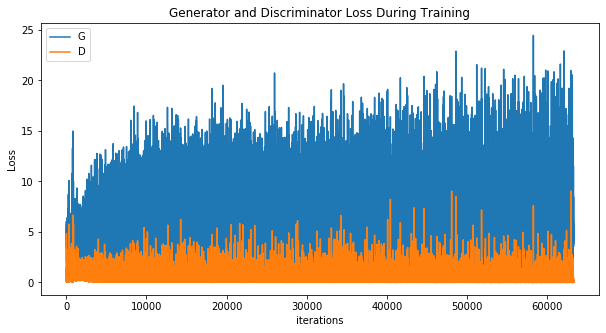

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
noise = torch.randn(32, 100,1, 1, device=device)
img = generator(noise)

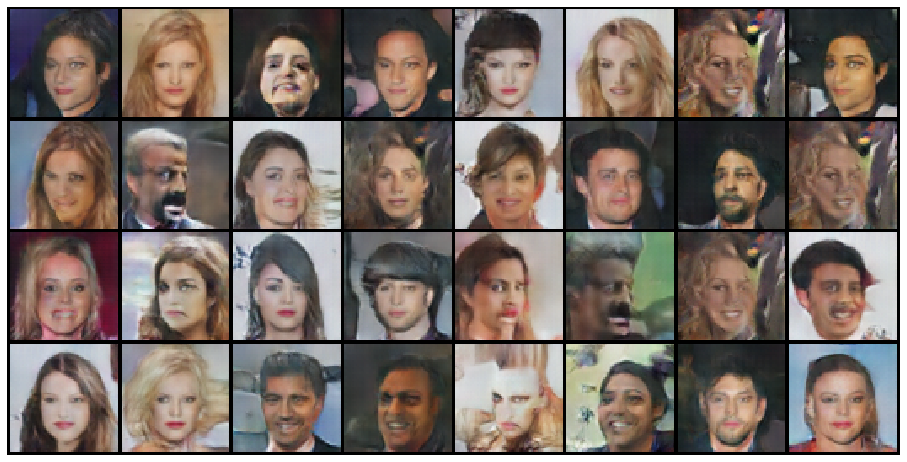

In [24]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")
img_list = [vutils.make_grid(img, padding=2, normalize=True).cpu().detach()]

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
plt.show()

In [25]:
# vector woman
images = []
vec_woman = noise[1].view(-1, 100, 1, 1)
vec_man = noise[2].view(-1, 100, 1, 1)
vec_woman = vec_woman 
woman = generator(vec_woman)
man = generator(vec_man)
images.append(vutils.make_grid(woman, padding=2, normalize=True).cpu().detach())
images.append(vutils.make_grid(woman, padding=2, normalize=True).cpu().detach())

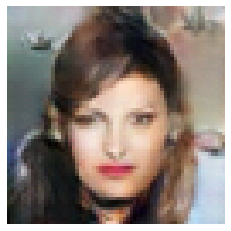

In [26]:

plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in images]
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


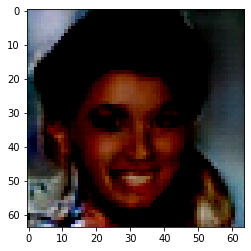

In [20]:
plt.imshow(np.transpose(man[0].cpu().detach(),(1,2,0)))
plt.show()